<a href="https://colab.research.google.com/github/dmachlanski/ncrm-causality-2021/blob/main/labs/day_2/Tutorial_Sodium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem setting
This is a simplified version of a model that simulates the effect of sodium intake on blood pressure. Officially proposed in ([Luque-Fernandez et al. 2019](https://academic.oup.com/ije/article/48/2/640/5248195)).


We are given three covariates: age (A), sodium (S), and blood pressure (B). We are interested in the effect of sodium intake on blood pressure. In addition, we know that age affects both variables - confounder. Here is the assumed causal graph:

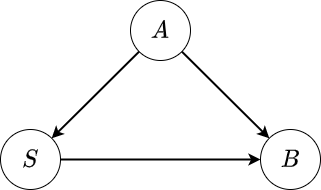

Give some simulation details, sample count, equations, etc.

The target is ATE - give the equation, explain (average effect across the entire population).

$$A = \mathcal{N}(65, 5)$$ \\
$$
S=
    \begin{cases}
        1 & \text{ if } A/18 + \mathcal{N}(0, 1) > 3.5 \\ 
        0 & \text{ otherwise } 
    \end{cases}
$$ \\
$$B = ATE \times S + 2 A + \mathcal{N}(0, 1)$$
$$ATE = 1.05$$

$$ATE = \mathbb{E}[\mathcal{Y}_1 - \mathcal{Y}_0]$$

$$\epsilon_{ATE} = \left| \frac{1}{n}\sum \limits_{i=1}^{n}(\hat{y}_1^{(i)} - \hat{y}_0^{(i)}) - ATE \right|$$

In [ ]:
def ate_error(pred_te, true_ate):
  return np.abs(np.mean(pred_te) - true_ate)

In [ ]:
!pip install econml

     |████████████████████████████████| 3.0MB 5.1MB/s 
     |████████████████████████████████| 358kB 31.3MB/s 
     |████████████████████████████████| 133kB 27.9MB/s 
     |████████████████████████████████| 81kB 7.4MB/s 
  Created wheel for shap: filename=shap-0.38.1-cp37-cp37m-linux_x86_64.whl size=490490 sha256=62c219bd086705fa02491c0f917d8a49d78ac145f54ad036e62c35db7367f1df
  Stored in directory: /root/.cache/pip/wheels/a8/fb/e4/88012be41842b9be62ae18d82d1b1e880daf8539d1fef1fa00
Successfully built shap
  Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0


In [40]:
from econml.metalearners import XLearner
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt

In [41]:
!wget https://github.com/dmachlanski/ncrm-causality-2021/raw/main/labs/day_2/data/sodium_10k.npz

--2021-06-15 00:02:41--  https://github.com/dmachlanski/ncrm-causality-2021/raw/main/labs/day_2/data/sodium_10k.npz
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dmachlanski/ncrm-causality-2021/main/labs/day_2/data/sodium_10k.npz [following]
--2021-06-15 00:02:41--  https://raw.githubusercontent.com/dmachlanski/ncrm-causality-2021/main/labs/day_2/data/sodium_10k.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 240724 (235K) [application/octet-stream]
Saving to: ‘sodium_10k.npz.1’

sodium_10k.npz.1    100%[===================>] 235.08K  --.-KB/s    in 0.03s   

2021-06-15 00:02:41 (8.54 MB/s

In [42]:
data = np.load('sodium_10k.npz')

In [ ]:
data.files

['x', 't', 'y']

In [43]:
for f in data.files:
  print(f'{f}: {data[f].shape}')

x: (10000,)
t: (10000,)
y: (10000,)


In [44]:
X = data['x'].reshape(-1, 1)
T = data['t'].reshape(-1, 1)
Y = data['y'].reshape(-1, 1)

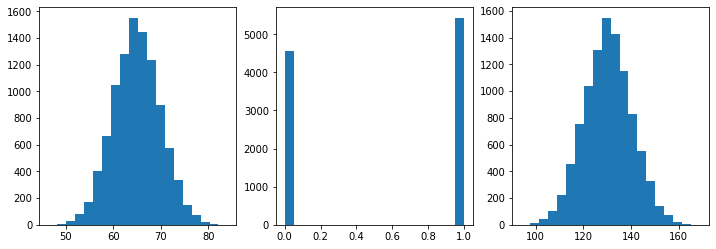

In [48]:
bins=20
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].hist(X, bins=bins)
axs[1].hist(T, bins=bins)
axs[2].hist(Y, bins=bins)
plt.show()

In [ ]:
x_train, x_test, t_train, t_test, y_train, y_test = train_test_split(X, T, Y, test_size=0.2)

In [ ]:
# X-Learner
xl = XLearner(models=RandomForestRegressor(), propensity_model=RandomForestClassifier())
xl.fit(y_train, t_train.flatten(), X=x_train)

xl_te_in = xl.effect(x_train)
xl_te_out = xl.effect(x_test)

In [ ]:
# Random Forest
rf = RandomForestRegressor()
rf.fit(np.concatenate([x_train, t_train], axis=1), y_train.flatten())

rf_y0_in = rf.predict(np.concatenate([x_train, np.zeros_like(t_train)], axis=1))
rf_y1_in = rf.predict(np.concatenate([x_train, np.ones_like(t_train)], axis=1))

rf_y0_out = rf.predict(np.concatenate([x_test, np.zeros_like(t_test)], axis=1))
rf_y1_out = rf.predict(np.concatenate([x_test, np.ones_like(t_test)], axis=1))

rf_te_in = rf_y1_in - rf_y0_in
rf_te_out = rf_y1_out - rf_y0_out

$$w_i = \frac{t_i}{P(t_i|x_i)} + \frac{1-t_i}{1-P(t_i|x_i)}$$

In [ ]:
def get_ps_weights(clf, x, t):
  z = np.squeeze(t)
  clf.fit(x, z)
  e = clf.predict_proba(x).T[1].T + 0.0001
  return z / e + ((1.0 - z) / (1.0 - e))

In [ ]:
prop_clf = RandomForestClassifier()
weights = get_ps_weights(prop_clf, x_train, t_train)

rf_ipsw = RandomForestRegressor()
rf_ipsw.fit(np.concatenate([x_train, t_train], axis=1), y_train.flatten(), sample_weight=weights)

rf_ipsw_y0_in = rf_ipsw.predict(np.concatenate([x_train, np.zeros_like(t_train)], axis=1))
rf_ipsw_y1_in = rf_ipsw.predict(np.concatenate([x_train, np.ones_like(t_train)], axis=1))

rf_ipsw_y0_out = rf_ipsw.predict(np.concatenate([x_test, np.zeros_like(t_test)], axis=1))
rf_ipsw_y1_out = rf_ipsw.predict(np.concatenate([x_test, np.ones_like(t_test)], axis=1))

rf_ipsw_te_in = rf_ipsw_y1_in - rf_ipsw_y0_in
rf_ipsw_te_out = rf_ipsw_y1_out - rf_ipsw_y0_out

In [ ]:
true_ate = 1.05

xl_ate_in = ate_error(xl_te_in, true_ate)
xl_ate_out = ate_error(xl_te_out, true_ate)

rf_ate_in = ate_error(rf_te_in, true_ate)
rf_ate_out = ate_error(rf_te_out, true_ate)

rf_ipsw_ate_in = ate_error(rf_ipsw_te_in, true_ate)
rf_ipsw_ate_out = ate_error(rf_ipsw_te_out, true_ate)

In [ ]:
results = []
results.append(['XL', xl_ate_in, xl_ate_out])
results.append(['RF', rf_ate_in, rf_ate_out])
results.append(['RF (IPSW)', rf_ipsw_ate_in, rf_ipsw_ate_out])

cols = ['Method', 'ATE in', 'ATE out']

df = pd.DataFrame(results, columns=cols)
df

,Method,ATE in,ATE out
0,XL,0.012796,0.001052
1,RF,0.033017,0.032111
2,RF (IPSW),0.034084,0.026492


In [ ]:
def mean_ci(data, ci=0.95):
  l_mean = np.mean(data)
  lower, upper = st.t.interval(ci, len(data)-1, loc=l_mean, scale=st.sem(data))
  return l_mean, lower, upper

In [ ]:
xl_ate_bounds = mean_ci(xl_te_out)
rf_ate_bounds = mean_ci(rf_te_out)
rf_ipsw_ate_bounds = mean_ci(rf_ipsw_te_out)

results = []
results.append(['XL', xl_ate_bounds[0], xl_ate_bounds[1], xl_ate_bounds[2]])
results.append(['RF', rf_ate_bounds[0], rf_ate_bounds[1], rf_ate_bounds[2]])
results.append(['RF (IPSW)', rf_ipsw_ate_bounds[0], rf_ipsw_ate_bounds[1], rf_ipsw_ate_bounds[2]])

cols = ['Method', 'ATE mean', 'CI lower', 'CI upper']

df = pd.DataFrame(results, columns=cols)
df

,Method,ATE mean,CI lower,CI upper
0,XL,1.048948,[1.0109578513357556],[1.0869378266956544]
1,RF,1.017889,0.975103,1.06067
2,RF (IPSW),1.023508,0.980807,1.06621


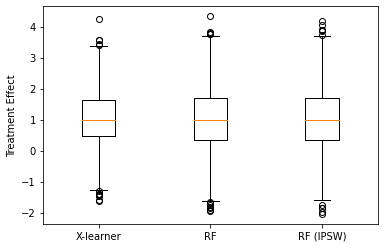

In [ ]:
plt.figure()
plt.boxplot([xl_te_out.flatten(), rf_te_out, rf_ipsw_te_out], labels=['X-learner', 'RF', 'RF (IPSW)'])
plt.ylabel('Treatment Effect')

plt.show()

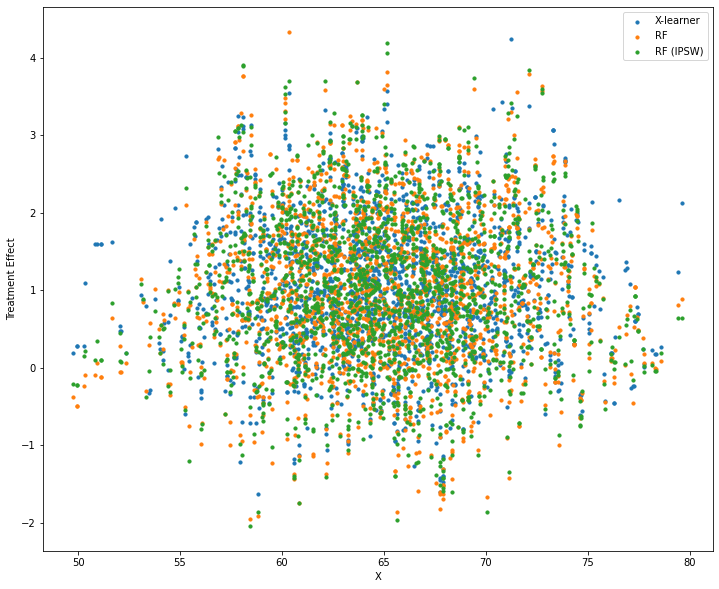

In [ ]:
plt.figure(figsize=(12, 10))
m_size = 10
plt.scatter(x_test, xl_te_out, label="X-learner", s=m_size)
plt.scatter(x_test, rf_te_out, label="RF", s=m_size)
plt.scatter(x_test, rf_ipsw_te_out, label="RF (IPSW)", s=m_size)
plt.xlabel('X')
plt.ylabel('Treatment Effect')
plt.legend()
plt.show()